DELORO Yonatan

# Machine Learning et applications
# TP3 - Descente de gradient, classifieurs linéaires

Pour le 30 avril 2017

In [63]:
import  numpy as np
import matplotlib.pyplot as plt
import math
from tools import *

plt.rcParams['figure.figsize'][0] = 12

# 1. Données et classifieur bayésien naif

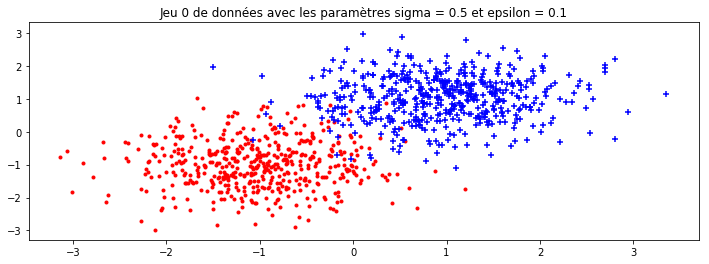

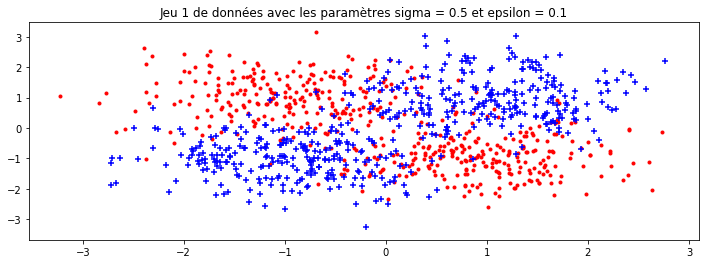

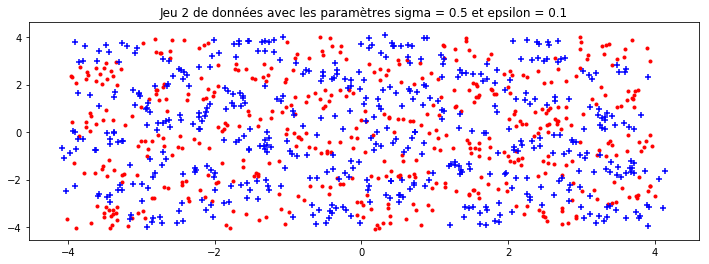

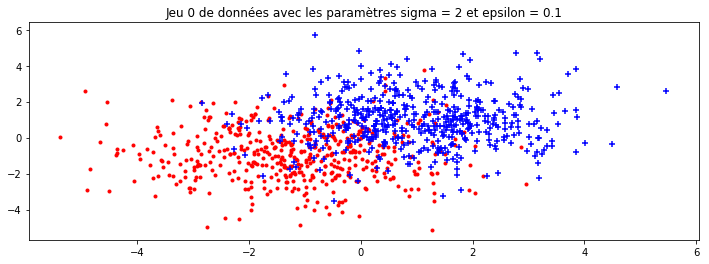

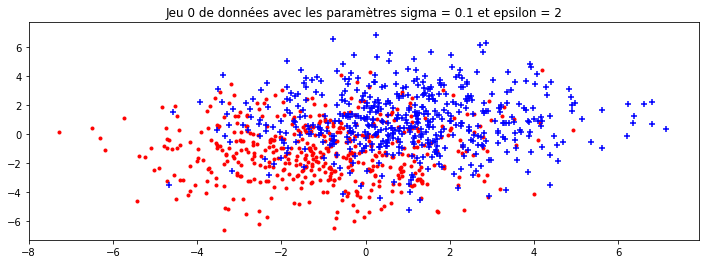

In [79]:
def question_11(type,sig,eps):
    ### Donnees artificielles
    xgentrain,ygentrain = gen_arti(data_type=type,sigma=sig,nbex=1000,epsilon=eps)
    plt.figure()
    plot_data(xgentrain,ygentrain)
    plt.title("Jeu "+str(type)+ " de données avec les paramètres sigma = "+str(sig)+" et epsilon = "+str(eps))
    plt.show()
    
question_11(0,0.5,0.1) #jeu de données, sigma, epsilon
question_11(1,0.5,0.1)
question_11(2,0.5,0.1)

question_11(0,2,0.1)
question_11(0,0.1,2)

1.1. 

La fonction gen_arti permet donc de visualiser trois jeux différents de données répartis en deux labels. On peut jouer sur la variance $\sigma$ de la gaussienne qui génère les données d'un même label autour de la zone géographique prédéfinie (un point pour le jeu 0, une droite pour le jeu 1, une série de droites pour le jeu 2) ainsi que sur le bruit $\epsilon$ des données descriptives x et y d'un label.

Visualisation de 10 exemples de '0' ou de '6'


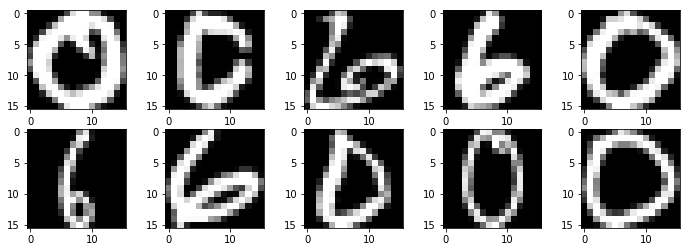

In [65]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    
def question_12():
    ### Donnees reelles
    plt.figure()
    xuspstrain,yuspstrain = load_usps("USPS_train.txt")
    x06train,y06train = get_usps([0,6],xuspstrain,yuspstrain)
    print("Visualisation de 10 exemples de '0' ou de '6'")
    for i in range(1,11):
        plt.subplot(2,5,i)
        show_usps(x06train[i])
    plt.show()
    
question_12()

1.2. 

Les données USPS correspondent donc à des vecteurs de dimension 256 (images de taille (16,16)) répartis en 10 labels (chiffres de 0 à 9).
Il nous semble que classifier un chiffre face à un autre chiffre est plus efficace que le classifier contre l'ensemble des autres chiffres quand la forme de ce chiffre est complexe (très différente selon les écritures) et se confond avec celle d'un autre chiffre en particulier. En effet, comparer le chiffre x à tous les autres chiffres revient à séparer son image moyenne de l'image constituée de la somme des images moyennes de ces chiffres, et ainsi les particularités du chiffre y avec lequel le chiffre x peut se confondre risquent d'être noyées dans l'image de la somme. Il serait donc plus efficace dans ce cas de classifier x contre y que contre tous les autres.

In [66]:
class Classifier_Bayes():
    def __init__(self):
        self.labels=[] #liste des différents labels rencontrés avec l'ensemble d'apprentissage
        self.mu=dict() #associe à chaque classe un vecteur des moyennes selon chaque dimension
        self.sigma=dict()  #associe à chaque classe un vecteur des variances selon chaque dimension

    def predict(self,data):
        (n,d)=np.shape(data) #nombre de données, nombre de dimensions pour décrire une donnée
        nb_labels=len(self.labels) #nombre de labels
        proba=np.zeros((n,nb_labels)) #de taille nb_donnees*nb_labels : probabilité que le label soit associé à la donnée
        
        for id_label in range(nb_labels):
            l=self.labels[id_label]
            #produit des probabilités conditionnelles des différentes dimensions de la donnée sachant le label
            proba[:,id_label]=np.sum(np.log(1/(math.sqrt(2*math.pi)*self.sigma[l]+pow(10,-10))*np.exp(-pow(data-self.mu[l],2)/(2*pow(self.sigma[l],2)+pow(10,-10)))+pow(10,-10)),axis=1)
            proba[:,id_label]+=math.log(1/nb_labels)
        results=np.argmax(proba,axis=1)  #de taille nb_donnees : quel label associé chaque donnée ?

        #On retourne les labels prédits
        id_to_label= lambda id:self.labels[id]
        id_to_label=np.vectorize(id_to_label)
        return id_to_label(results)

    def fit(self,data,labels):
        (n,d)=np.shape(data)  #nombre de données, nombre de dimensions pour décrire une donnée
        self.labels=list(set(labels)) #liste des différents labels possibles
        for l in self.labels:
            self.mu[l]=data[labels==l,:].mean(0) 
            self.sigma[l]=data[labels==l,:].std(0,ddof=1)

    def score(self,data,labels):
        return (self.predict(data)==labels).mean()

1.3.1. 

Dans le classifieur bayésien naif que l'on implémente, on fait l'hypothèse qu'on n'a pas de connaissance a priori sur la composition de l'ensemble de test (telle que "il contient plus de chiffres "3" que de chiffre "4") et on choisit donc en conséquence $p(y)=1/10$ pour tout label y. Par conséquent, pour classer un exemple x, la règle de décision consiste simplement à trouver le label y qui maximise la probabilité a posterirori : $p(x|y)=\prod_{i=1}^d p(x_i|y)$

Performances du classifieur de Bayes sur le jeu 0 avec les paramètres sigma = 0.5 et epsilon = 0.1
score :  0.974


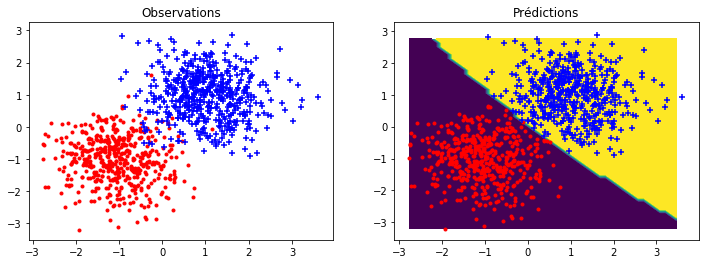

Performances du classifieur de Bayes sur le jeu 1 avec les paramètres sigma = 0.5 et epsilon = 0.1
score :  0.492


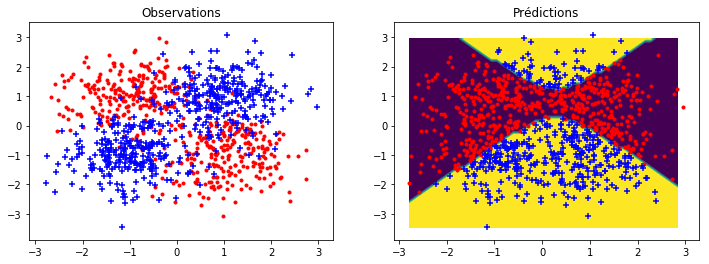

Performances du classifieur de Bayes sur le jeu 2 avec les paramètres sigma = 0.5 et epsilon = 0.1
score :  0.474


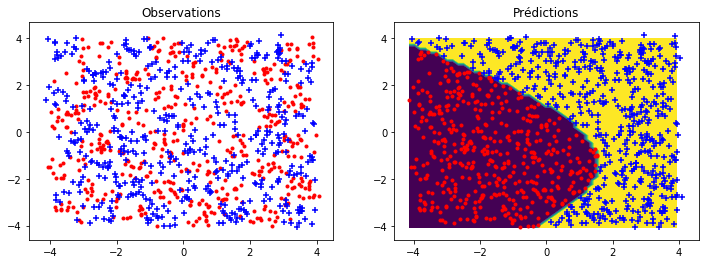

In [67]:
def question_132(type):
    #Test du classifieur de Bayes sur les données artificielles 
    print("Performances du classifieur de Bayes sur le jeu " +str(type)+ " avec les paramètres sigma = 0.5 et epsilon = 0.1")
    xgentrain,ygentrain = gen_arti(data_type=type,sigma=0.5,nbex=1000,epsilon=0.1)
    xgentest,ygentest = gen_arti(data_type=type,sigma=0.5,nbex=1000,epsilon=0.1)
    C=Classifier_Bayes()
    C.fit(xgentrain,ygentrain)
    predicts=C.predict(xgentest)
    score=C.score(xgentest,ygentest)
    print("score : ", score)

    plt.figure()
    plt.subplot(1,2,1)
    plot_data(xgentest,ygentest)
    plt.title("Observations")
    plt.subplot(1,2,2)
    plot_frontiere(xgentest,C.predict,step=50)
    plot_data(xgentest,predicts)
    plt.title("Prédictions")
    plt.show()

question_132(0) #jeu de données artificielles
question_132(1)
question_132(2)

1.3.2.

On a affiché les prédictions des labels des données de test (figure de droite) en regard de leurs véritables labels (figure de gauche). On visualise également les frontières de décision.

On observe que le classifieur bayésien naif arrive à bien prédire les labels du jeu 0 de données artificielles. En effet, les moyennes et variances de chaque dimension (abcisses $x_1$ et ordonnées $x_2$) des données d'apprentissage sont différentes pour les deux labels. Pour une donnée de test $(x_1,x_2)$, $p(x_1|y)$ sera donc différente pour les deux labels y, de même que $p(x_2|y)$. Ainsi on s'attend à une bonne prédiction en choisissant le label $y$ qui maximise $p(x_1|y)p(x_2|y)$.

Au contraire, on observe que le classifieur n'arrive pas à prédire les labels des données du jeu 1. En effet, les moyennes des abcisses ($x_1$) et des ordonnées ($x_2$) des points de l'ensemble d'apprentissage sont globalement nulles pour chacun des deux labels, et de même les variances sont identiques. Ainsi les distributions gaussiennes pour chaque dimension $x_1$ et $x_2$
sont les mêmes pour les deux labels, et $p(x|y)=p(x_1|y)p(x_2|y)$ est donc identique pour les deux labels y. 
C'est donc l'hypothèse d'indépendance des dimensions du classifieur qui est donc la cause de la mauvaise classification pour ce jeu de données.
On rencontre le même problème pour le jeu 2.

I. Tous les chiffres
score  :  0.41504733433


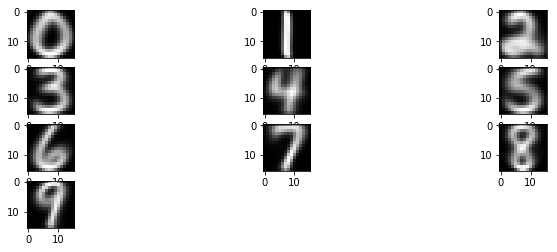

II. Un chiffre contre un autre : 0 contre 6
score :  0.867674858223


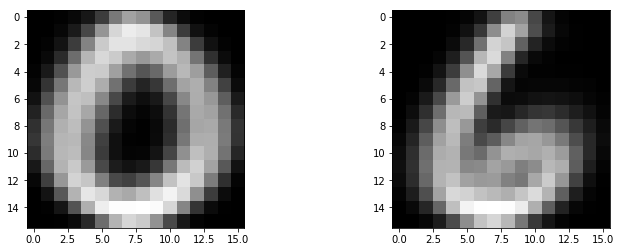

III. Un chiffre contre tous les autres : 0
score :  0.892874937718


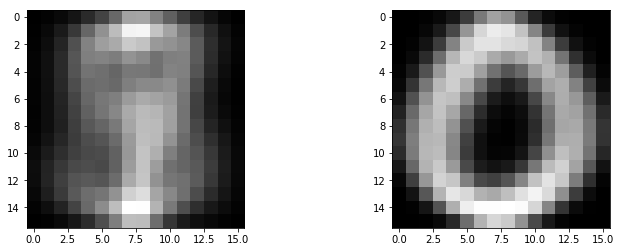

IV.Un chiffre contre tous les autres : 6
score :  0.597907324365


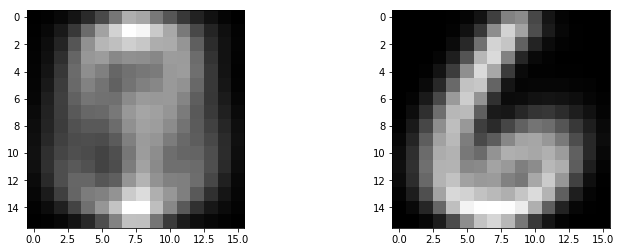

In [68]:
def question_133():
    #Test du classifieur de Bayes Naif sur les données réelles
    
    print("I. Tous les chiffres")

    xuspstrain,yuspstrain = load_usps("USPS_train.txt")
    xuspstest,yuspstest = load_usps("USPS_test.txt")
    C=Classifier_Bayes()
    C.fit(xuspstrain,yuspstrain)
    predicts=C.predict(xuspstest)
    score=C.score(xuspstest,yuspstest)
    print("score  : ", score)
    
    plt.figure()
    for i in range(0,10):
        plt.subplot(4,3,i+1)
        show_usps(np.array([m for m in C.mu.values()])[i,:])
    plt.show()
    

    print("II. Un chiffre contre un autre : 0 contre 6")

    x06train,y06train = get_usps([0,6],xuspstrain,yuspstrain)
    x06test,y06test = get_usps([0,6],xuspstest,yuspstest)
    C=Classifier_Bayes()
    C.fit(x06train,y06train)
    predicts=C.predict(x06test)
    score=C.score(x06test,y06test)
    print("score : ", score)
    
    plt.figure()
    plt.subplot(1,2,1)
    show_usps(np.array([m for m in C.mu.values()])[0,:])
    plt.subplot(1,2,2)
    show_usps(np.array([m for m in C.mu.values()])[1,:])
    plt.show()

    
    print("III. Un chiffre contre tous les autres : 0")

    all_against_0=lambda x: (x==0)
    all_against_0=np.vectorize(all_against_0)
    x0train,x0test = xuspstrain,xuspstest
    y0train = all_against_0(yuspstrain)
    y0test = all_against_0(yuspstest)
    C=Classifier_Bayes()
    C.fit(x0train,y0train)
    predicts=C.predict(x0test)
    score=C.score(x0test,y0test)
    print("score : ", score)
    
    plt.figure()
    plt.subplot(1,2,1)
    show_usps(np.array([m for m in C.mu.values()])[0,:])
    plt.subplot(1,2,2)
    show_usps(np.array([m for m in C.mu.values()])[1,:])
    plt.show()

    
    print("IV.Un chiffre contre tous les autres : 6")

    all_against_6=lambda x: (x==6)
    all_against_6=np.vectorize(all_against_6)
    x6train,x6test = xuspstrain,xuspstest
    y6train = all_against_6(yuspstrain)
    y6test = all_against_6(yuspstest)
    C=Classifier_Bayes()
    C.fit(x6train,y6train)
    predicts=C.predict(x6test)
    score=C.score(x6test,y6test)
    print("score : ", score)
    
    plt.figure()
    plt.subplot(1,2,1)
    show_usps(np.array([m for m in C.mu.values()])[0,:])
    plt.subplot(1,2,2)
    show_usps(np.array([m for m in C.mu.values()])[1,:])
    plt.show()
    
    

question_133()

1.3.3.

Pour chacun des quatre classifieurs, on a visualisé les vecteurs $\mu$ de chaque classe comme des images : la valeur d'une cellule de la matrice $\mu$ d'une classe correspond à la probabilité que la forme d'un chiffre de cette classe passe par ce pixel. Ainsi une valeur élevée correspond à un pixel blanc, une valeur faible à un pixel noir de l'image. 

On obient un score de 0.42 avec un classifieur de Bayes naif sur les 10 labels.
Cette performance médiocre d'un classifieur unique sur les 10 labels suggère déjà l'idée de lui préférer un "tournoi" de classifieurs de Bayes binaires.

Observons maintenant les performances des deux classifieurs binaires proposés en question 1.2.
En classifiant le chiffre 0 contre le chiffre 6 avec le classifieur bayésien naif, on obtient un score de 0.87.
Si l'on classifie maintenant le chiffre 0 contre tous les autres, on obtient un score de 0.89 ; pour le chiffre 6 contre tous les autres on obtient un score de 0.60.

Par conséquent, classifier 6 contre 0 semble plus intéressant que le classifier contre tous les autres chiffres, car sa forme peut varier beaucoup d'une écriture à l'autre et que le 0 est le chiffre qui peut occasionner le plus de confusion avec lui. En revanche, classifier 0 contre tous les chiffres donne un meilleur score que contre le 6, car sa forme est plus "stable" (écart-type $\sigma$ moins important)

# 2. Descente de gradient

In [69]:
def optimize(fonc,dfonc,xinit,eps,max_iter):
    x_histo=[] #liste des points x_t au fil des itérations t
    f_histo=[] #liste des points f(x_t) au fil des itérations t
    grad_histo=[] #liste des points grad_f(x_t) au fil des itérations t
    iter=0 #compteur du nombre d'itérations
    x_histo.append(xinit)
    f_histo.append(fonc(x_histo[0]))
    grad_histo.append(dfonc(x_histo[0]))
    while (iter<max_iter): #critère d'arrêt
        iter+=1
        x_new=x_histo[iter-1]-eps*dfonc(x_histo[iter-1])
        x_histo.append(x_new)
        f_histo.append(fonc(x_new))
        grad_histo.append(dfonc(x_new))
    x_histo=np.array(x_histo)
    f_histo=np.array(f_histo)
    grad_histo=np.array(grad_histo)
    return (x_histo,f_histo,grad_histo)

Fonction 1D f(x)=x*cos(x), petit pas


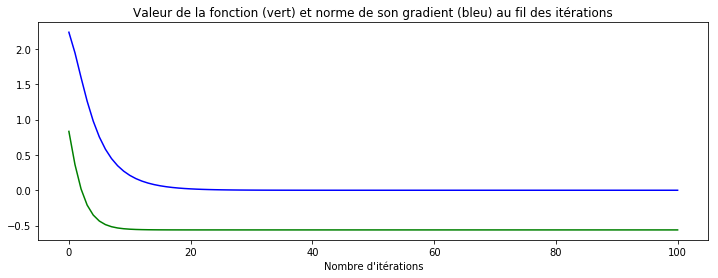

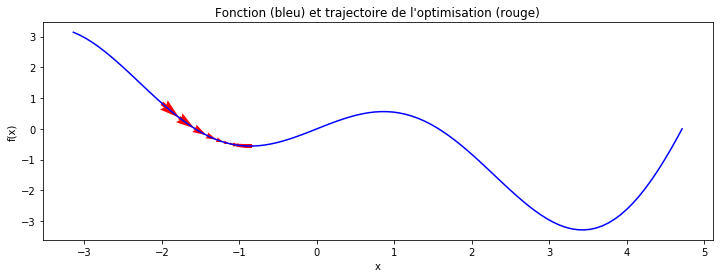

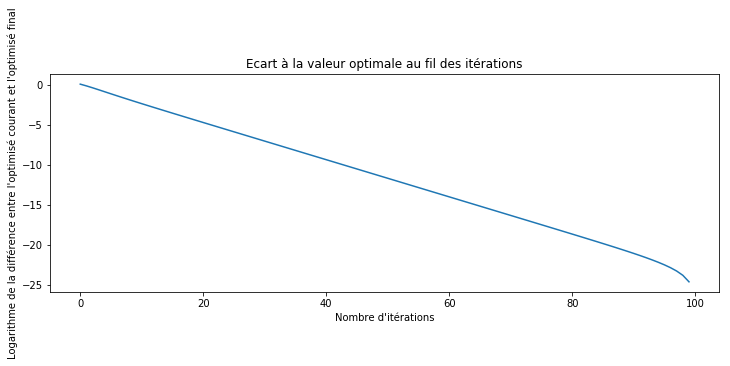

Fonction 1D f(x)=x*cos(x), grand pas


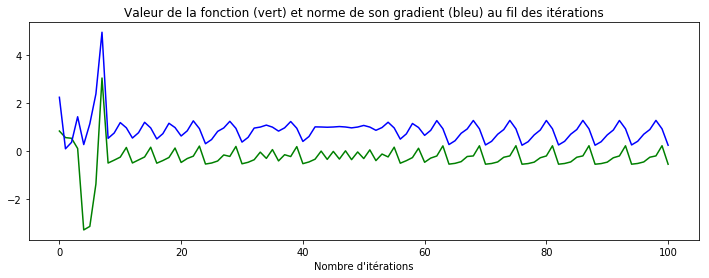

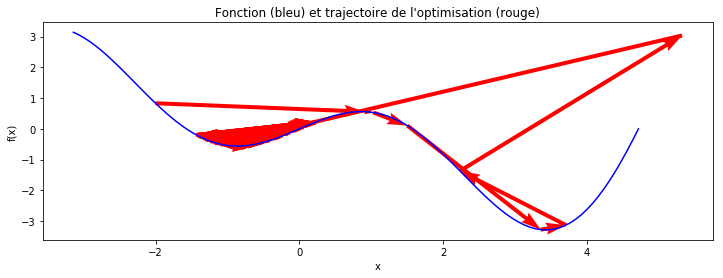

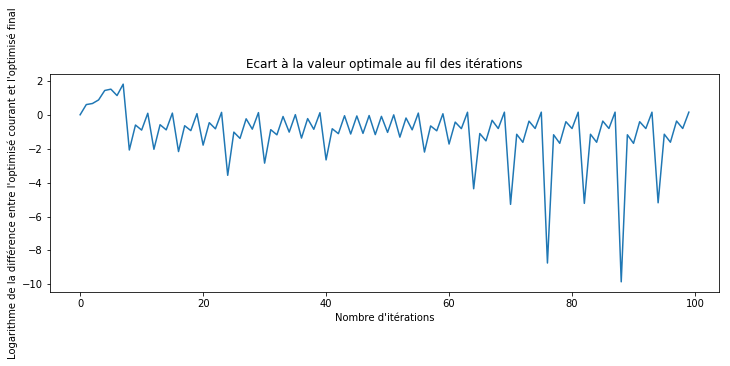

Fonction 2D Rosenbrock/banana


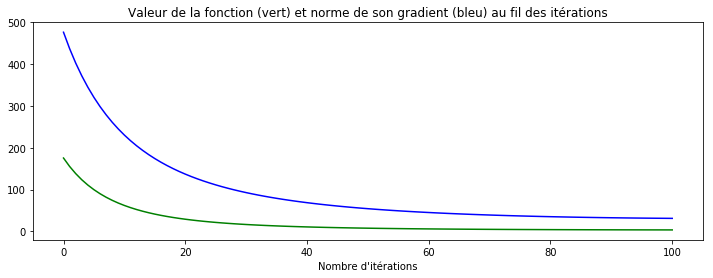

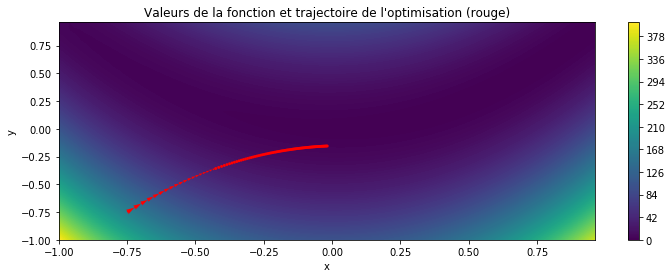

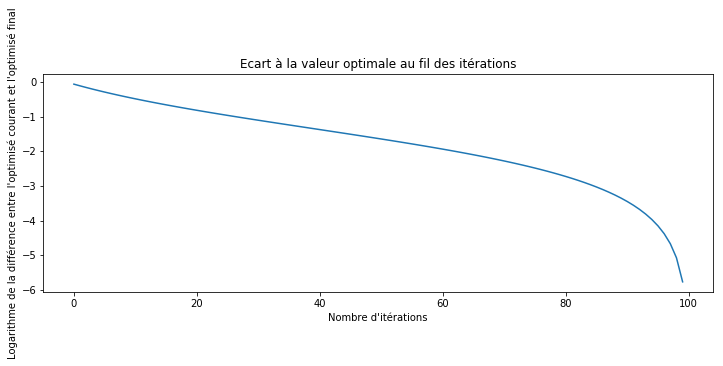

In [70]:
def optimize_1D(f,df,x_ini,eps,nb_iter):
    #Pour une fonction de |R dans |R
    #Affiche les valeurs de f et de la norme du gradient de f au fil de la descente de gradient
    #Affiche la trajectoire de l'optimisation
    #Affiche la courbe de l'erreur logarithmique à l'estimée finale au fil des itérations
    
    (x_histo,f_histo,grad_histo)=optimize(f,df,x_ini,eps,nb_iter)
    plt.figure()
    plt.plot(list(range(nb_iter+1)),f_histo,color="green")
    plt.plot(list(range(nb_iter+1)),abs(grad_histo),color="blue")
    plt.title("Valeur de la fonction (vert) et norme de son gradient (bleu) au fil des itérations")
    plt.xlabel("Nombre d'itérations")
    plt.show()

    x=np.linspace(-math.pi,1.5*math.pi,100).flatten()
    f=np.vectorize(f)
    plt.figure()
    plt.plot(x,f(x),color="blue")
    Q=plt.quiver(x_histo[:-1],f_histo[:-1],x_histo[1:]-x_histo[:-1],f_histo[1:]-f_histo[:-1], scale_units='xy', angles='xy', scale=1,color="red")
    plt.title("Fonction (bleu) et trajectoire de l'optimisation (rouge)")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.show()

    plt.figure()
    plt.plot(list(range(nb_iter)),[math.log(abs(x_histo[-1]-x_histo[i])) for i in range(nb_iter)])
    plt.title("Ecart à la valeur optimale au fil des itérations")
    plt.xlabel("Nombre d'itérations")
    plt.ylabel("Logarithme de la différence entre l'optimisé courant et l'optimisé final")
    plt.show()

def optimize_2D(f,df,x_ini,eps,nb_iter):
    #Pour une fonction de |R^2 dans |R
    #Affiche les valeurs de f et de la norme du gradient de f au fil de la descente de gradient
    #Affiche la trajectoire de l'optimisation dans le plan 2D
    #Affiche la courbe de l'erreur logarithmique à l'estimée finale au fil des itérations
    
    (x_histo,f_histo,grad_histo)=optimize(f,df,x_ini,eps,nb_iter)
    plt.figure()
    plt.plot(list(range(nb_iter+1)),f_histo,color="green")
    plt.plot(list(range(nb_iter+1)),np.linalg.norm(grad_histo,axis=1),color="blue")
    plt.title("Valeur de la fonction (vert) et norme de son gradient (bleu) au fil des itérations")
    plt.xlabel("Nombre d'itérations")
    plt.show()
    
    plt.figure()
    grid,xx,yy = make_grid(xmin=-1,xmax=1,ymin=-1,ymax=1,step=50)
    C=plt.contourf(xx,yy,np.reshape(np.array([f(point) for point in grid]),xx.shape),256)
    #plt.scatter(x_histo[:,0],x_histo[:,1],color="red")
    Q=plt.quiver(x_histo[:-1,0],x_histo[:-1,1],x_histo[1:,0]-x_histo[:-1,0],x_histo[1:,1]-x_histo[:-1,1], scale_units='xy', angles='xy', scale=1,color="red")
    plt.colorbar(C)
    plt.title("Valeurs de la fonction et trajectoire de l'optimisation (rouge)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    plt.figure()
    plt.plot(list(range(nb_iter)),[math.log(np.linalg.norm(x_histo[-1]-x_histo[i])) for i in range(nb_iter)])
    plt.title("Ecart à la valeur optimale au fil des itérations")
    plt.xlabel("Nombre d'itérations")
    plt.ylabel("Logarithme de la différence entre l'optimisé courant et l'optimisé final")
    plt.show()

def question_22():
    #Fonction en 1D f(x)=x*cos(x)
    f = lambda x : x*math.cos(x)
    df = lambda x : math.cos(x)-x*math.sin(x)
    print("Fonction 1D f(x)=x*cos(x), petit pas")
    optimize_1D(f,df,-2,0.1,100) #x_ini, pas eps,nb_iter
    print("Fonction 1D f(x)=x*cos(x), grand pas")
    optimize_1D(f,df,-2,1.3,100)

    #Fonction en 2D Rosenbrock/banana
    f = lambda x : 100*pow(x[1]-pow(x[0],2),2)+pow(1-x[0],2)
    df = lambda x : np.array([200*(x[1]-pow(x[0],2)),-400*x[0]*(x[1]-pow(x[0],2))-2*(1-x[0])])
    print("Fonction 2D Rosenbrock/banana")
    optimize_2D(f,df,np.array([-0.75,-0.75]),pow(10,-4),100) #x_ini, pas eps, nb_iter

question_22()

2.2.

Pour la fonction f(x)=xcos(x), on observe bien, dès 10 ou 20 itérations de l'algorithme du gradient appliqué avec un pas de 0.1, la convergence du gradient de la fonction vers 0 et la convergence de la fonction vers un minimum local. Par ailleurs, on observe que le logarithme de l'écart entre l'estimée du point minimisant à t et l'estimée finale décroit linairement avec les itérations, donc cet écart décroit exponentiellement avec les itérations.

Aussi, le tracé de la trajectoire de l'optimisation montre l'importance du choix du pas $\epsilon$:
- si l'on prend un pas trop petit, l'algorithme converge vers le minimum local le plus proche
- si l'on prend un pas trop grand, on peut explorer des mimimum "plus globaux" mais il y a un risque que l'algorithme ne converge pas.
Un algorithme de gradient à pas variable pourrait être une solution à ce problème, mais nous nous contenterons de cet algorithme pour la suite, en choisissant de manière pas trop absurde le point initial.

Sur la fonction de Rosenbrock, on observe également la convergence vers (0,0), effectivement minimum, depuis le point initial (-0,75,-0,75). Pour observer cette convergence, il faut cependant choisir un pas plus petit que pour l'optimisation de la fonction précédente, 10^(-4) en l'occurrence, (car le gradient est très grand), et en conséquence attendre un plus grand nombre d'itérations.

# 3.  Applications : classification plug-in et régression logistique

3.1.
Posons :

$
\widetilde{X}=\begin{pmatrix}
       1 & x^0_1 & ... & x^0_d \\
       1 & x^1_1 & ... & x^1_d \\
       \vdots & \vdots & \ddots & \vdots \\
       1 & x^n_1 & ... & x^n_d \\
\end{pmatrix},
Y= 
\left( \begin{array}{c}
Y^0 \\
Y^1 \\
\vdots \\
Y^n
\end{array} \right),
W=
\left( \begin{array}{c}
W_0 \\
W_1 \\
\vdots \\
W_d
\end{array} \right)
$

On notera aussi $\widetilde{X}^i$ le vecteur constitué par la ligne i de la matrice $\widetilde{X}$


- En classification plug-in, la fonction de coût que l'on cherche à minimiser correspond à l'erreur des moindres carrés qui s'écrit :
$$l(W,X,Y)=\frac{1}{n} \|\widetilde{X}W-Y\|^2$$



En développant :
$$l(W,X,Y)  =  \frac{1}{n} \langle \widetilde{X}W-Y,\widetilde{X}W-Y \rangle =  \frac{1}{n} W^T\widetilde{X}^T\widetilde{X}W + \frac{1}{n}Y^TY - \frac{2}{n}Y^T\widetilde{X}W $$

Le gradient de la fonction de coût est donc :

$$\nabla_W l(W,X,Y) = \frac{1}{n} (\widetilde{X}^T\widetilde{X}+(\widetilde{X}^T\widetilde{X})^T)W - \frac{2}{n} Y^T\widetilde{X}=\frac{2}{n}(\widetilde{X}^T\widetilde{X}W - Y^T\widetilde{X})$$ 

- En classification par régression logistique, la fonction de coût que l'on cherche à minimiser correspond à l'opposé de la log-vraisemblance (que l'on veut en effet maximale), soit :

$$l(W,X,Y)=-\sum_{i=1}^N \log{\frac{1}{1+\exp{-Y^i\widetilde{X}^iW}}}= \sum_{i=1}^N \log{(1+\exp{-Y^i\widetilde{X}^iW})}$$

Ainsi, le gradient de la fonction de coût est :

$$\nabla_W l(W,X,Y) = \sum_{i=1}^N \frac{\exp{-Y^i\widetilde{X}^iW}}{1+\exp{-Y^i\widetilde{X}^iW}}-Y^i{\widetilde{X}^i}^T =  \sum_{i=1}^N \left( \frac{-Y^i\exp{-Y^i\widetilde{X}^iW}}{1+\exp{-Y^i\widetilde{X}^iW}}\right) {\widetilde{X}^i}^T$$ 


- Ainsi, on choisira le $W$ qui minimise la fonction de perte empirique $l(W,X,Y)$ sur la base d'aprentissage $(X,Y)$ grâce à l'algorithme de descente de gradient implémentée dans la fonction "optimize", en choisissant un pas adéquat et en initialisant par exemple W à $(0....0)$.
Etant donné un ensemble de test de données X, on pourra en prédire les labels Y donnés par le signe de $\widetilde{X}W$.


In [71]:
def mse(w,data,label):
    #Renvoie le cout en w pour la régression plug-in
    predictions=np.dot(data,np.transpose(w)).flatten()
    diff=predictions-label
    return np.mean(diff*diff)

def grad_mse(w,data,label):
    #Renvoie le gradient du cout en w pour la régression plug-in
    (n,d)=np.shape(data)
    predictions=np.dot(data,np.transpose(w))
    return 2/n*(np.dot(np.transpose(data),predictions).flatten()-np.dot(np.transpose(label),data))

In [72]:
def sigm(x):
    #Fonction sigmoide
    return 1/(1+math.exp(-x))

def reglog(w,data,label):
    #Renvoit le cout en w pour la régression logistique
    ps=np.multiply(np.reshape(label,(-1,1)),np.dot(data,np.transpose(w)))
    rlog=lambda x: math.log(sigm(x))
    rlog=np.vectorize(rlog)
    return -np.mean(rlog(ps))

def grad_reglog(w,data,label):
    #Renvoit le gradient du cout en w pour la régression logistique
    (n,d)=np.shape(data)
    label=np.reshape(label,(-1,1))
    ps=np.multiply(label,np.dot(data,np.transpose(w)))
    sig=lambda x:sigm(x)
    sig=np.vectorize(sig)
    tmp=np.multiply(np.multiply(label,np.exp(-ps)),sig(ps))
    return -np.mean(np.multiply(np.tile(tmp,(1,d)),data),axis=0)

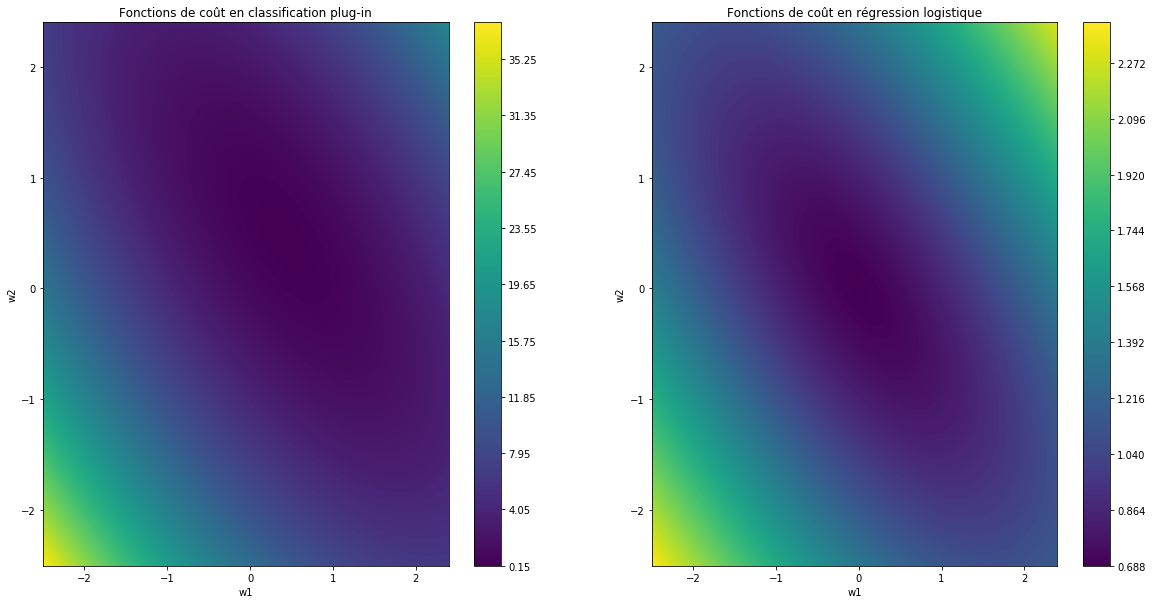

In [73]:
def question_34():
    xgentrain,ygentrain = gen_arti(data_type=0,sigma=0.5,nbex=100,epsilon=0.1)

    #on considère un biais nul (donc n'ajoute pas la colonne de 1)
    #les données de xgentrain sont de dimensions 2
    #on regarde l'évolution des fonctions de couts avec w1 et w2

    grid,xx,yy = make_grid(xmin=-2.5,xmax=2.5,ymin=-2.5,ymax=2.5,step=50)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    C=plt.contourf(xx,yy,np.reshape(np.array([mse(point,xgentrain,ygentrain) for point in grid]),xx.shape),256)
    plt.colorbar(C)
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.title("Fonctions de coût en classification plug-in")

    plt.subplot(1,2,2)
    C=plt.contourf(xx,yy,np.reshape(np.array([reglog(point,xgentrain,ygentrain) for point in grid]),xx.shape),256)
    plt.colorbar(C)
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.title("Fonctions de coût en régression logistique")
    plt.show()

question_34()

3.4. On a tracé ci-dessus les deux fonctions de coût, pour la classification plug-in et pour la régression logistique, en fonction de $w_1$ et $w_2$ (en considérant un bias $w_0$ nul). On remarque que :
- pour la classification plug-in, le coût varie plus rapidement que pour la régression logistique selon la valeur des poids (gradient plus fort)
- pour la classification plug-in, le coût semble minimal sur une vallée en creux qui semble rester bordée même à l'infini par ses deux versants, quand, pour la régression logistique, il est minimal que dans un puits borné. 

Le fait que le minimum soit plus localisée avec la régession logistique qu'avec la classification plug-in est due à la forme de la fonction sigmoide qui discrimine plus nettement l'appartenance à un label.

In [74]:
def signe(x):
    if x>=0:
        return 1
    return -1

class Classifier_Binary():
    #Classifieur binaire général, munis des méthodes predict et fit,
    #et dont vont hériter les classifieurs par plug-in et par régression logistique
    
    def __init__(self):
        self.w=-1 #vecteur des poids

    def predict(self,data):
        (n,d)=np.shape(data)
        col_id=np.reshape((np.ones(n)),(n,1)) # vecteur colonne de 1 (pour tenir compte du biais)
        data=np.concatenate((col_id,data),axis=1)  # matrice de "design"

        predictions=np.dot(data,np.transpose(self.w))
        sign = lambda x:signe(x)
        sign=np.vectorize(sign)
        return sign(predictions).flatten()

    def score(self,data,labels):
        return (self.predict(data)==labels).mean()
    
class Classifier_PlugIn(Classifier_Binary):
    def __init__(self):
        super().__init__()

    def predict(self,data):
        return super().predict(data)

    def fit(self,data,labels,eps,nb_iter,affiche=False):
        #affiche=True montre l'évolution du coût au cours de la descente de gradient
        (n,d)=np.shape(data)
        col_id=np.reshape((np.ones(n)),(n,1)) # vecteur colonne de 1 (pour tenir compte du biais)
        data=np.concatenate((col_id,data),axis=1)  # matrice de "design"

        cost = lambda x : mse(x,data,labels)
        grad_cost = lambda x : grad_mse(x,data,labels)
        winit = np.zeros((1,d+1))
        (w_histo,cost_histo,grad_cost_histo) = optimize(cost,grad_cost,winit,eps,nb_iter)
        self.w = w_histo[-1]

        if affiche:
            plt.figure()
            plt.plot(list(range(nb_iter+1)),cost_histo,color="green")
            plt.title("Coûts pour la classification plug-in \
            \n au fil des itérations de l'algorithme du gradient")
            plt.xlabel("Nombre d'itérations")
            plt.show()

    def score(self,data,labels):
        return super().score(data,labels)

class Classifier_RegLog(Classifier_Binary):
    def __init__(self):
        super().__init__()

    def predict(self,data):
        return super().predict(data)

    def fit(self,data,labels,eps,nb_iter,affiche=False):
         #affiche=True montre l'évolution du coût au cours de la descente de gradient
        (n,d)=np.shape(data)
        col_id=np.reshape((np.ones(n)),(n,1)) # vecteur colonne de 1
        data=np.concatenate((col_id,data),axis=1)  # matrice de "design"

        cost = lambda x : reglog(x,data,labels)
        grad_cost = lambda x : grad_reglog(x,data,labels)
        winit = np.zeros((1,d+1))
        (w_histo,cost_histo,grad_cost_histo) = optimize(cost,grad_cost,winit,eps,nb_iter)
        self.w = w_histo[-1]

        if affiche:
            plt.figure()
            plt.plot(list(range(nb_iter+1)),cost_histo,color="yellow")
            plt.title("Coûts pour la classification par régression logistique \
            \n au fil des itérations de l'algorithme du gradient")
            plt.xlabel("Nombre d'itérations")
            plt.show()

    def score(self,data,labels):
        return super().score(data,labels)


Remarque d'implémentation : on fait hériter les deux classifieurs - par méthode Plug-In et par régression logistique - d'une classe de Classifieur Binaire plus générale, puisque seules leurs fonctions fit diffèrent (une fois l'apprentissage réalisé, l'inférence par le signe est la même).

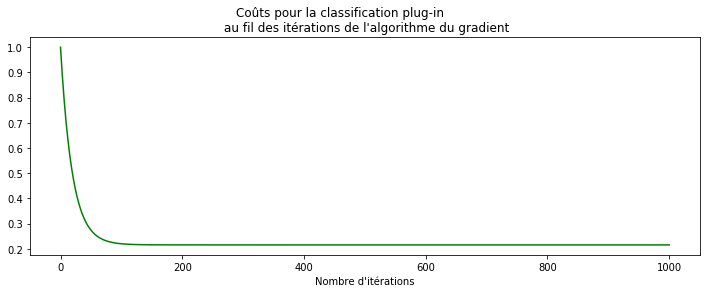

score :  0.974


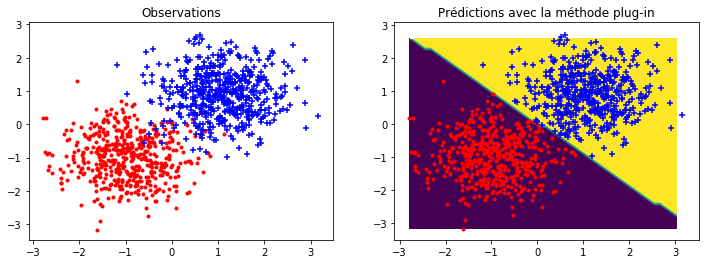

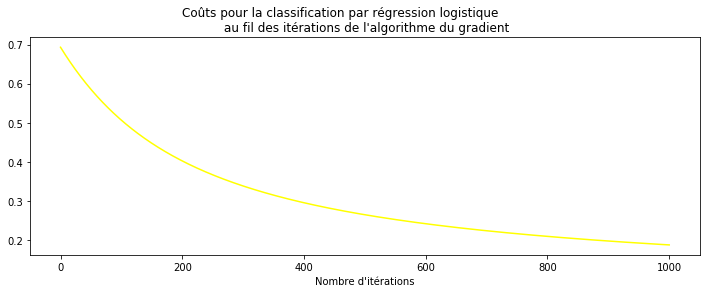

score :  0.974


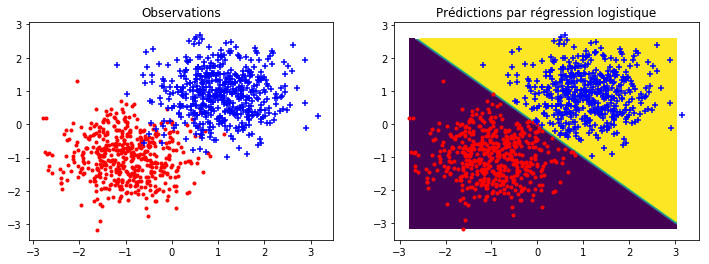

In [75]:
def question_35(type):
    #Données artificielles
    xgentrain,ygentrain = gen_arti(data_type=type,sigma=0.5,nbex=1000,epsilon=0.1)
    xgentest,ygentest = gen_arti(data_type=type,sigma=0.5,nbex=1000,epsilon=0.1)
    #Paramètres de l'algorithme du gradient
    eps=0.005
    nb_iter=1000

    #A. Classifieur binaire plug-in
    #1.Apprentissage : évolution du coût au fil de l'algorithme du gradient
    C_PlugIn=Classifier_PlugIn()
    C_PlugIn.fit(xgentrain,ygentrain,eps,nb_iter,True)
    #2. Test : frontières de décision
    predicts_PlugIn=C_PlugIn.predict(xgentest)
    score=C_PlugIn.score(xgentest,ygentest)
    print("score : ", score)
    plt.figure()
    plt.subplot(1,2,1)
    plot_data(xgentest,ygentest)
    plt.title("Observations")
    plt.subplot(1,2,2)
    plot_frontiere(xgentest,C_PlugIn.predict,step=50)
    plot_data(xgentest,predicts_PlugIn)
    plt.title("Prédictions avec la méthode plug-in")
    plt.show()

    #B. Classifieur binaire par régression logistique
    #1.Apprentissage : évolution du cout au fil de l'algorithme du gradient
    C_RegLog=Classifier_RegLog()
    C_RegLog.fit(xgentrain,ygentrain,eps,nb_iter,True)
    #2. Test : frontières de décision
    predicts_RegLog=C_RegLog.predict(xgentest)
    score=C_RegLog.score(xgentest,ygentest)
    print("score : ", score)
    plt.figure()
    plt.subplot(1,2,1)
    plot_data(xgentest,ygentest)
    plt.title("Observations")
    plt.subplot(1,2,2)
    plot_frontiere(xgentest,C_RegLog.predict,step=50)
    plot_data(xgentest,predicts_RegLog)
    plt.title("Prédictions par régression logistique")
    plt.show()

question_35(0) #type du jeu des données artificielles

3.5.

- Expérimentations sur le jeu 0 de données artificielles 

-> a) Apprentissage

On trace d'abord l'évolution de la fonction de coût sur la base d'apprentissage au fil des itérations de la descente de gradient (effectuée avec un pas de 0.005 et une initialisation des poids à 0).
Pour la classification plug-in, le coût chute très rapidement à 0.2 au bout de 75 itérations pour converger vers cette valeur. Dans le cas de régression logistique, le coût diminue plus progressivement au fil des itérations mais semble converger vers une valeur plus faible que 0.2.

-> b) Test

Avec le vecteur des poids appris sur la base d'apprentissage, on affiche les prédictions des labels des données de test (figure de droite) en regard de leurs véritables labels (figure de gauche).
On visualise également les frontières de décision.

On remarque que les deux classifieurs arrivent à prédire les labels des données de façon satisfaisante (scores supérieur à 95%). On remarque de même que les outliers (points rouges dans la zone des points bleus) sont bien sûr mal classifiés par ces classifieurs linéaires. Et si la base d'apprentissage comprenait effectivement de tels outliers, on comprend pourquoi la fonction de coût ne convergeait pas exactement vers 0.

Enfin on observe un léger décalage de la frontière de décision entre les deux classifieurs (plug-in et régression logistique), certains points proches de la frontière migrant ainsi d'une classe à l'autre.

- Commentaires sur les valeurs de $f_W$

Les valeurs élevées (en valeur absolue) de $f_W$ correspondent à des données auxquelles on attribue assez nettement un label, ou encore qui sont loin de la frontière de décision ; quand les valeurs faibles de $f_W$ correspondent à des points où la classification est difficile (près de la frontière de décision).

On ne peut pas vraiment comparer les valeurs de $f_W$ des deux modèles, puisque, dans le modèle de régression logistique la fonction sigmoide tend à "discriminer" les classes, et aboutit par conséquent à des valeurs de $f_W$ plus élevées en valeur absolues que dans le modèle de classification plug-in.

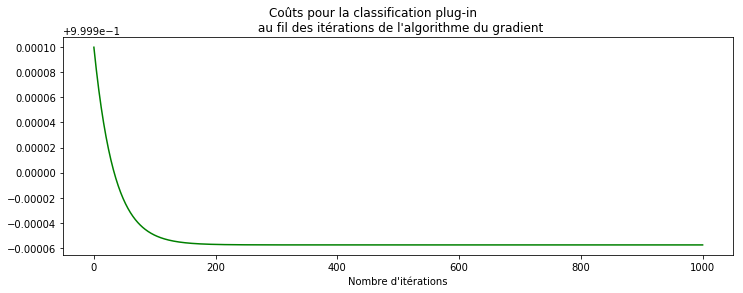

score :  0.505


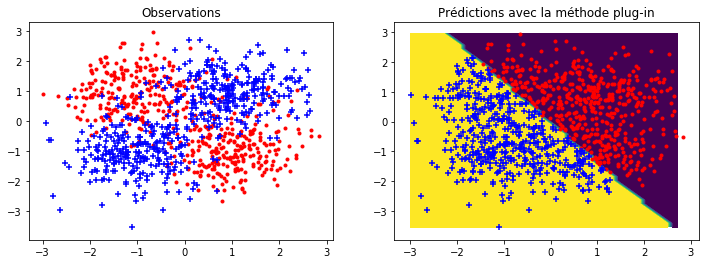

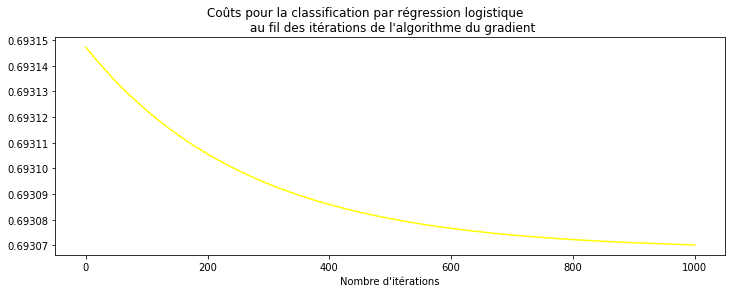

score :  0.503


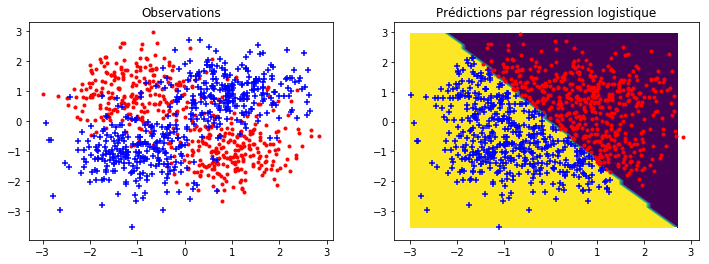

In [76]:
question_35(1) #type du jeu des données artificielles

3.5. (suite)

- Expérimentations sur le jeu 1 de données artificielles

Tout comme le classifieur de Bayes naif, les classifieurs binaires par méthode plug-in et par régression logistique, échouent à prédire les labels du jeu 1 de données artificielles.
Cela est cette fois due à la linéarité du classifieur. En effet, les points bleus étant situés au Nord-Est et au Sud-Ouest, les contributions des données de la base à l'apprentissage de $w$ oscillent entre (-1,-1) et (+1,+1), et par conséquent, les poids du w finalement appris sont nuls !

Le jeu 2 présente le même problème de classification.

I. Un chiffre contre un autre : 0 contre 6
I.A. Par classification plug-in


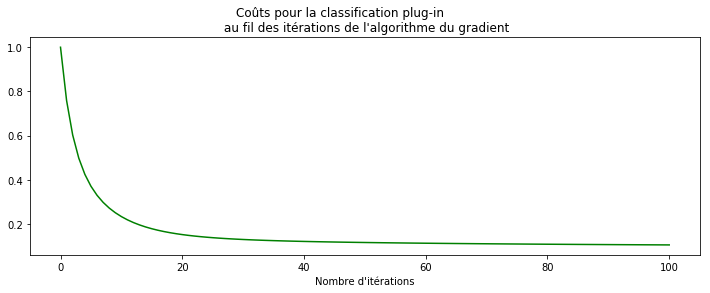

score :  0.982986767486

I.B. Par régression logistique


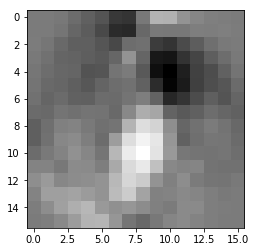

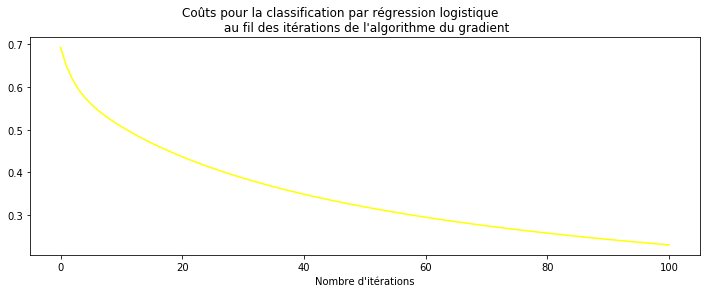

score :  0.943289224953

II. Un chiffre contre tous les autres : le 6
II.A. Par classification plug-in


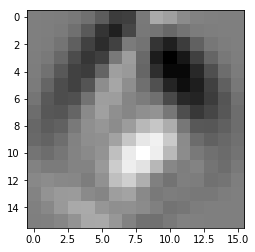

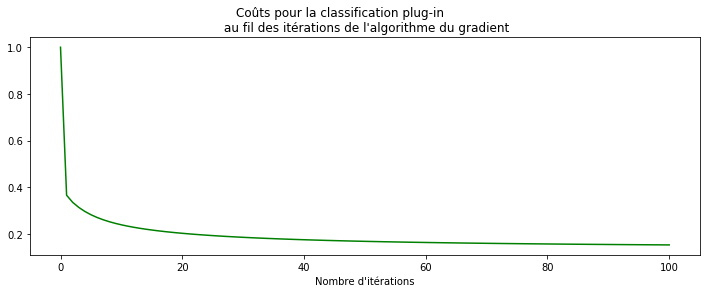

score :  0.977578475336

II.B. Par régression logistique


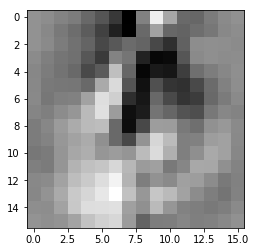

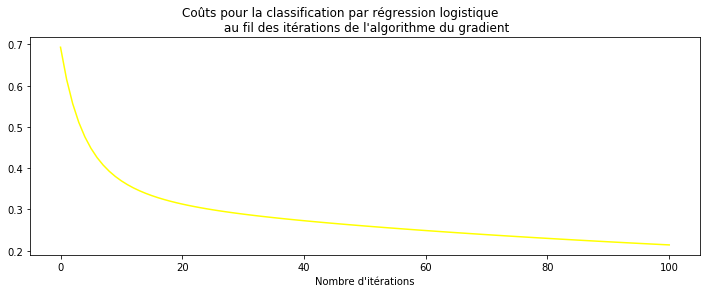

score  :  0.915296462382


In [77]:
def question_36():
    xuspstrain,yuspstrain = load_usps("USPS_train.txt")
    xuspstest,yuspstest = load_usps("USPS_test.txt")
    #Paramètres algorithme du gradient
    eps=0.005
    nb_iter=100

    print("I. Un chiffre contre un autre : 0 contre 6")

    x06train,y06train = get_usps([0,6],xuspstrain,yuspstrain)
    x06test,y06test = get_usps([0,6],xuspstest,yuspstest)
    #Pour ramener "0" et "6" à "-1" et "+1"
    f=lambda x:int(x/3. -1)
    f=np.vectorize(f)
    y06train=f(y06train)
    y06test=f(y06test)

    print("I.A. Par classification plug-in")
    #1.Apprentissage : Evolution du cout au fil de l'algorithme du gradient
    C_PlugIn=Classifier_PlugIn()
    C_PlugIn.fit(x06train,y06train,eps,nb_iter,True)
    #2. Test : score
    predicts_PlugIn=C_PlugIn.predict(x06test)
    score=C_PlugIn.score(x06test,y06test)
    show_usps(np.reshape((C_PlugIn.w)[:,1:],(16,16)))
    print("score : ", score)
    
    print("")
    print("I.B. Par régression logistique")
    #1.Apprentissage : Evolution du cout au fil de l'algorithme du gradient
    C_RegLog=Classifier_RegLog()
    C_RegLog.fit(x06train,y06train,eps,nb_iter,True)
    #2. Test : score
    predicts_RegLog=C_RegLog.predict(x06test)
    score=C_RegLog.score(x06test,y06test)
    show_usps(np.reshape((C_RegLog.w)[:,1:],(16,16)))
    print("score : ", score)

    print("")
    print("II. Un chiffre contre tous les autres : le 6")

    all_against_6=lambda x: (x==6)
    all_against_6=np.vectorize(all_against_6)
    x6train,x6test = xuspstrain,xuspstest
    y6train = all_against_6(yuspstrain)
    y6test = all_against_6(yuspstest)
    #Pour ramener "0" et "1" à "-1" et "+1"
    f=lambda x:int(2*x -1)
    f=np.vectorize(f)
    y6train=f(y6train)
    y6test=f(y6test)

    print("II.A. Par classification plug-in")
    #1.Apprentissage : Evolution du cout au fil de l'algorithme du gradient
    C_PlugIn=Classifier_PlugIn()
    C_PlugIn.fit(x6train,y6train,eps,nb_iter,True)
    #2. Test : score
    predicts_PlugIn=C_PlugIn.predict(x6test)
    score=C_PlugIn.score(x6test,y6test)
    show_usps(np.reshape((C_PlugIn.w)[:,1:],(16,16)))
    print("score : ", score)


    print("")
    print("II.B. Par régression logistique")
    #1.Apprentissage : Evolution du cout au fil de l'algorithme du gradient
    C_RegLog=Classifier_RegLog()
    C_RegLog.fit(x6train,y6train,eps,nb_iter,True)
    #2. Test : score
    predicts_RegLog=C_RegLog.predict(x6test)
    score=C_RegLog.score(x6test,y6test)
    show_usps(np.reshape((C_RegLog.w)[:,1:],(16,16)))
    print("score  : ", score)

question_36()

3.6.. Tout d'abord, on a affiché le vecteur des poids w appris (excepté le biais) comme une image. La valeur d'une cellule de la matrice de w peut s'interpréter comme la probabilité conditionnelle du label "+1" sachant que ce pixel appartient à la forme du chiffre à prédire. Par conséquent, dans l'exemple du classifieur du chiffre 0 ("-1") contre le chiffre 6 ("+1"), si un pixel appartient à la forme d'un chiffre à prédire et si la case de ce pixel apparait en blanc dans l'image de w (forte probabilité du label "+1"), alors ce pixel apporte une présomption pour que ce chiffre soit un "6". Si en revanche, la case apparait en noir (faible probabilité du label "+1"), ce pixel apporte une présomption pour que ce chiffre soit un "0". En blanc apparaissent donc les pixels propres au chiffre 6 et en noir les pixels caractéristiques du 0.

On remarque qu'avec les classifieurs plug-in et par régression logistique, on obtient de bien meilleurs scores (tous au dessus de 90%), que ce soit en classification binaire chiffre contre chiffre, ou chiffre contre tous les autres chiffres. Les scores restent aussi plus élevées dans le premier problème de classification énoncé.

Enfin, on remarque qu'il faut attendre plus d'itérations pour la classificaion par régression logistique que par méthode plug-in pour observer la convergence de la fonction de coût.